In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('dataset.csv')
df.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [6]:
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

In [8]:
df_recency = df.groupby(by='CustomerID', as_index=False)['PurchaseDate'].max()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,CustomerID,LastPurchaseDate,Recency
0,1011,2023-05-08,33
1,1025,2023-05-20,21
2,1029,2023-06-10,0
3,1046,2023-04-28,43
4,1049,2023-05-28,13


In [10]:
frequency_df = df.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['PurchaseDate'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,1011,2
1,1025,1
2,1029,1
3,1046,1
4,1049,1


In [12]:
df['Total'] = df['TransactionAmount']  # Total spent by each customer
monetary_df = df.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,1011,1129.02
1,1025,359.29
2,1029,704.99
3,1046,859.82
4,1049,225.72


In [14]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(columns='LastPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,1011,33,2,1129.02
1,1025,21,1,359.29
2,1029,0,1,704.99
3,1046,43,1,859.82
4,1049,13,1,225.72


In [16]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

In [18]:
rfm_df['R_rank_norm'] = (rfm_df['R_rank'] / rfm_df['R_rank'].max()) * 100
rfm_df['F_rank_norm'] = (rfm_df['F_rank'] / rfm_df['F_rank'].max()) * 100
rfm_df['M_rank_norm'] = (rfm_df['M_rank'] / rfm_df['M_rank'].max()) * 100

In [20]:
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,1011,33,2,1129.02,47.331910,97.301587,97.885835
1,1025,21,1,359.29,64.727855,47.407407,32.135307
2,1029,0,1,704.99,100.000000,47.407407,66.807611
3,1046,43,1,859.82,27.908218,47.407407,83.298097
4,1049,13,1,225.72,78.762006,47.407407,21.247357


In [22]:
rfm_df['RFM_Score'] = 0.15 * rfm_df['R_rank_norm'] + 0.28 * rfm_df['F_rank_norm'] + 0.57 * rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)

In [24]:
rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,1011,4.51
1,1025,2.07
2,1029,3.32
3,1046,3.25
4,1049,1.86
5,1082,2.69
6,1086,1.53


In [26]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 4.5, "Top Customers",
                                       np.where(rfm_df['RFM_Score'] > 4, "High value Customer",
                                                np.where(rfm_df['RFM_Score'] > 3, "Medium Value Customer",
                                                         np.where(rfm_df['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))

In [28]:
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,1011,4.51,Top Customers
1,1025,2.07,Low Value Customers
2,1029,3.32,Medium Value Customer
3,1046,3.25,Medium Value Customer
4,1049,1.86,Low Value Customers
5,1082,2.69,Low Value Customers
6,1086,1.53,Lost Customers
7,1104,1.38,Lost Customers
8,1108,3.51,Medium Value Customer
9,1120,3.84,Medium Value Customer


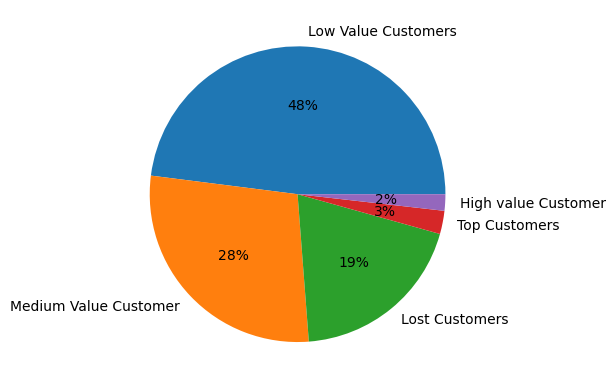

In [30]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()